# Spatial analysis of viral regions
**20201013, cmdoret**

I have extracted the positions of viral sequences in the A. castellanii assemblies of C3 and Neff strains and retrieved the contact profile of those regions. Visual inspection of the map hinted that some of the viral integration may have an insulating potential.

Here I quantify and visualise those contact profiles and inspect what is the genetic neighbourhood of those viral regions.

In [29]:
from os.path import join
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as ss
DAT = join('..', '..', 'data', 'out')
VIRDAT = join(DAT, 'virus')
strains = ["C3", "Neff"]

# All data structs will be nested in a dictionary with strain as key.
# This makes generation harder to read, but querying more convenient
# {str: df}
borders = {s: pd.read_csv(join(VIRDAT, 'spatial', f'{s}_borders.tsv'), sep='\t') for s in strains}
# {str: {id: np.array[i,j]}}
pileups = {s: json.load(open(join(VIRDAT, 'spatial', f'{s}_borders.json'))) for s in strains}
for s in pileups.keys(): pileups[s] = {int(i): np.array(w) for i, w in pileups[s].items()}

# Make an empty 3D array of shape N_coords x height x width
# {str: np.array[i,j,k]}
win_arr = {s: np.zeros((len(pileups[s].items()), *pileups[s][0].shape)) for s in pileups.keys()}
# Fill the 3D array with windows values
for s in pileups.keys():
    for i, w in pileups[s].items():
        win_arr[s][i] = w

# Drop positions with NaN scores
for s in strains:
    valid_mask = ~np.isnan(borders[s].score)
    borders[s] = borders[s].loc[valid_mask, :]
    borders[s] = borders[s].reset_index(drop=True)
    win_arr[s] = win_arr[s][valid_mask, :, :]
    
# Load gene annotations
annot = {s: pd.read_csv(join(DAT, 'hgt', f'{s}_windows_hgt.tsv'), sep='\t') for s in strains}
for s in strains: annot[s]['LEN'] = annot[s].end - annot[s].start

# Load viral insertions coordinates
insert = {s: pd.read_csv(join(VIRDAT, f'{s}_summary.tsv'), sep='\t') for s in strains}


<IPython.core.display.Javascript object>


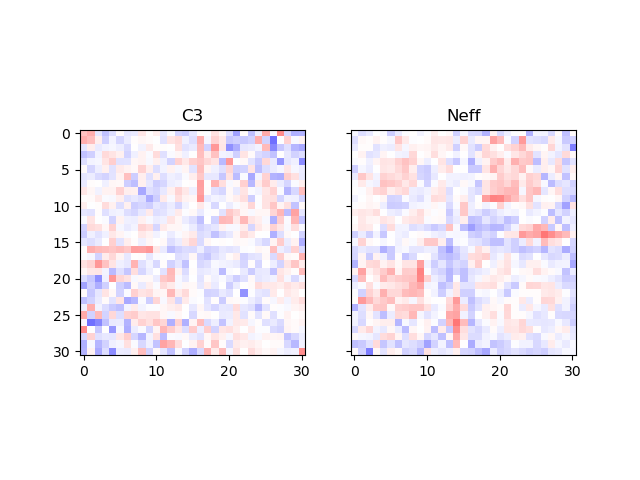

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [30]:
%matplotlib notebook
# Perhaps there is some faint insulation signal in Neff (losing with median)
# -> subset of insulating viral regions ?
def make_pileup(wins):
    if len(wins.shape) == 3:
        pileup = np.nanmean(wins, axis=0)
    else:
        pileup = wins
    pileup = np.nan_to_num(pileup)
    pileup = pileup + np.transpose(pileup) - np.diag(np.diag(pileup))
    return np.log2(pileup)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
for i, s in enumerate(strains):
    ax[i].imshow(make_pileup(win_arr[s]), cmap='bwr', vmin=-1, vmax=1)
    ax[i].set_title(s)

<IPython.core.display.Javascript object>


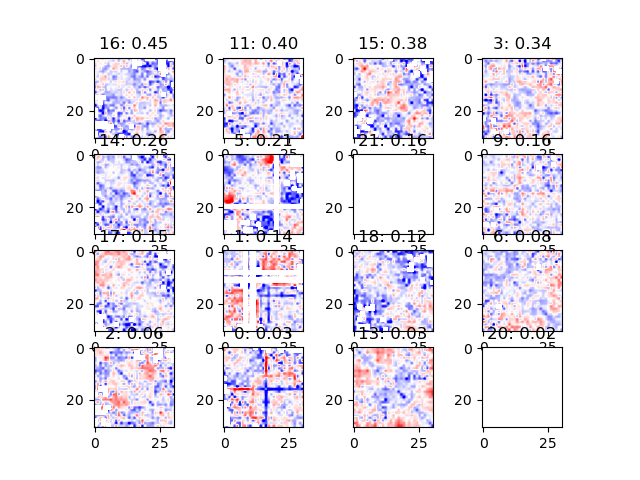

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()


In [31]:
%matplotlib notebook
# Windows 10, 9, 11 seem to have some insulation
# Misassemblies on windows 4, 20, 17
fig, ax = plt.subplots(4, 4)
for i, axi in zip(np.argsort(borders['C3'].score.values)[::-1][:16], ax.flat):
                    axi.imshow(make_pileup(win_arr['C3'][i, :, :]), cmap='bwr', vmin=-2, vmax=2)
                    axi.set_title(f"{i}: {borders['C3'].score[i]:.2f}")

<IPython.core.display.Javascript object>


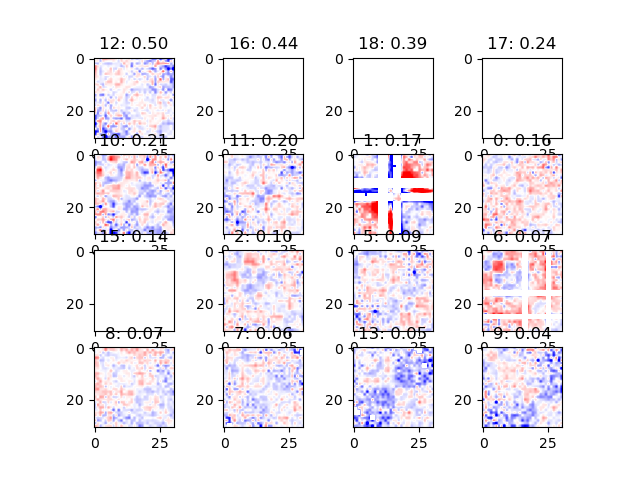

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()


In [32]:
%matplotlib notebook
# images 5, 8, 20 seem to have good insulation
fig, ax = plt.subplots(4, 4)
for i, axi in zip(np.argsort(borders['Neff'].score.values)[::-1][:16], ax.flat):
                    axi.imshow(make_pileup(win_arr['Neff'][i, :, :]), cmap='bwr', vmin=-2, vmax=2)
                    axi.set_title(f"{i}: {borders['Neff'].score[i]:.2f}")

### Manual inspection of viral regions
Here I look at the neighbourhood of viral regions that have strong insulation as reported by chromosight _and_ that look like borders.

<IPython.core.display.Javascript object>


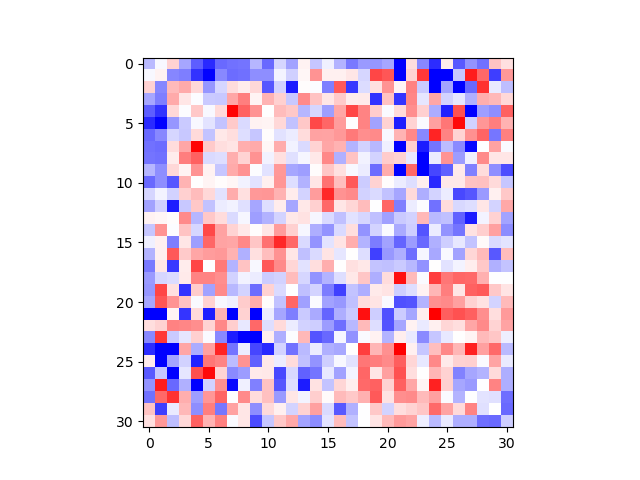

In [33]:
%matplotlib notebook

plt.imshow(make_pileup(win_arr['Neff'][5, :, :]), cmap='bwr', vmin=-1, vmax=1)

In [34]:
#insul = {'C3': [9, 10, 11], 'Neff': [5, 8, 20]}
insul = {s: np.argsort(borders[s].score.values)[::-1][:16] for s in strains}



In [35]:
insert

{'C3':      scaffold_32   699278   699331 aureococcus_anophagefferens_virus  0.943396
 0    scaffold_11   312945   314204               pandoravirus_dulcis  0.457346
 1    scaffold_33    34298    34467               pandoravirus_dulcis  0.585799
 2     scaffold_6   254704   254814               pandoravirus_dulcis  0.845455
 3     scaffold_9   641765   642129               pandoravirus_dulcis  0.231203
 4    scaffold_24  1106554  1108776               pandoravirus_dulcis  0.055806
 ..           ...      ...      ...                               ...       ...
 123   scaffold_4   928921   931629           pandoravirus_inopinatum  0.018464
 124   scaffold_3  1497063  1497142           pandoravirus_inopinatum  0.531646
 125   scaffold_4   931180   931385           pandoravirus_inopinatum  0.278049
 126  scaffold_33   150940   153346           pandoravirus_inopinatum  0.026683
 127   scaffold_7   437041   437218           pandoravirus_inopinatum  0.229508
 
 [128 rows x 5 columns],
 'Neff'

In [41]:
DIST = 10000
for s in strains: annot[s]['vir_region'] = 0

def get_neighbourhood(reg, ann, dist=1000):
    """Given a position, return annotations falling in the neighbourhood"""
    over_left  = (ann.start <= reg.end1   + dist) & (ann.start > reg.start1 - dist)
    over_right = (ann.end   >  reg.start1 - dist) & (ann.end   < reg.end1   + dist)
    same_chrom = ann.chrom == reg.chrom1
    return same_chrom & (over_left | over_right)

for s in strains:
    for i, reg in enumerate(insul[s]):
        border = borders[s].iloc[reg, :]
        reg_mask = get_neighbourhood(border, annot[s], dist=DIST)
        annot[s].loc[reg_mask, 'vir_region'] = i+1
    annot[s].vir_region = annot[s].vir_region.astype('category')
    annot[s]['isvir'] = (annot[s].vir_region != 0).astype('category')

In [42]:
for s in strains: print(f"{sum(annot[s].vir_region)} genes within {DIST} of viral regions in {s}")

9189 genes within 10000 of viral regions in C3
4463 genes within 10000 of viral regions in Neff


In [43]:
annot['C3'].columns

Index(['chrom', 'start', 'end', 'geneID', 'HGT', 'NEXON', 'GC', 'GCSKEW',
       'ATSKEW', 'ENTRO', '2MER', '3MER', '4MER', 'LEN', 'vir_region',
       'isvir'],
      dtype='object')

<IPython.core.display.Javascript object>


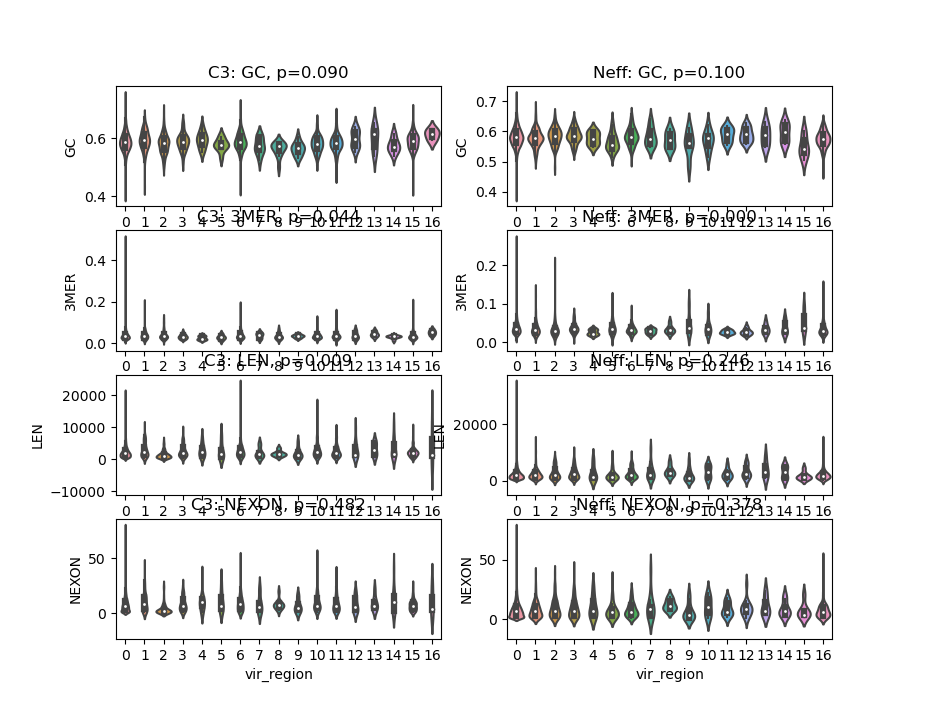

In [44]:
%matplotlib notebook
VAR = ['GC', '3MER', 'LEN', 'NEXON']
fig, axes = plt.subplots(len(VAR), 2)
for ax_row, var in zip(axes, VAR):
    for ax, s in zip(ax_row, strains):
        sns.violinplot(data=annot[s], x='vir_region', y=var, ax=ax)
        #sns.stripplot(data=annot[s].loc[annot[s].vir_region != 0, :], x='vir_region', y=var, hue='HGT', ax=ax, alpha=0.6)
        pval = ss.mannwhitneyu(annot[s].loc[annot[s].isvir==False, var], annot[s].loc[annot[s].isvir==True, var])[1]
        ax.set_title(f"{s}: {var}, p={pval:.3f}")

In [40]:
annot['C3'].loc[annot['C3'].isvir==True, :].sort_values('GCSKEW', ascending=False)

,chrom,start,end,geneID,HGT,NEXON,GC,GCSKEW,ATSKEW,ENTRO,2MER,3MER,4MER,LEN,vir_region,isvir
15265,scaffold_7,686021,686431,VMHBD_15256,0,1,0.691000,0.389291,0.074434,0.906603,0.047568,0.095390,0.186132,410,6,True
10504,scaffold_29,72154,72381,VMHBD_10499,0,1,0.515000,0.366990,-0.274227,0.960740,0.044373,0.133382,0.206242,227,16,True
10534,scaffold_29,245219,245732,VMHBD_10529,0,2,0.497000,0.344064,0.077535,0.977235,0.056881,0.187071,0.324440,513,16,True
4486,scaffold_16,993183,993716,VMHBD_04488,0,2,0.595000,0.334454,0.032099,0.962276,0.006928,0.028767,0.124074,533,2,True
4561,scaffold_16,1250977,1251781,VMHBD_04563,0,2,0.504500,0.321095,-0.211325,0.971592,0.049108,0.123444,0.199977,804,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15123,scaffold_7,285186,285485,VMHBD_15114,0,1,0.587000,-0.233390,0.089588,0.976188,0.003272,0.019863,0.053159,299,6,True
15296,scaffold_7,759529,760312,VMHBD_15287,0,1,0.670000,-0.243400,-0.144706,0.937936,0.030072,0.071507,0.156905,783,6,True
10514,scaffold_29,96043,100877,VMHBD_10509,0,7,0.647800,-0.256368,-0.151125,0.940286,0.027573,0.066610,0.164609,4834,16,True
15259,scaffold_7,670087,673587,VMHBD_15250,0,8,0.667500,-0.283971,-0.147482,0.926901,0.033434,0.078721,0.183382,3500,6,True
